## Screening Mammography Breast Cancer Detection
#### Grupo: Gabriel da Silva, Jhonatan Guilherme e Lílian Teixeira.

#### 1. Introdução
O intuito desse projeto é a criação de um modelo de Machine Learning que seja capaz de detectar se uma paciente possui ou não câncer de mama, baseado em uma mamografia. Para isso, utilizaremos o dataset [RSNA Screening Mammography Breast Cancer Detection](https://www.kaggle.com/competitions/rsna-breast-cancer-detection) disponibilizado pela **RSNA** (Radiological Society of North America) e hospedado no **Kaggle**.

O dataset é composto por 3 arquivos:
* **train.csv**: contém os dados de treino, com os IDs das imagens, a classificação (se a paciente possui ou não câncer de mama), entre outras características.
* **test.csv**: contém os dados de teste, com os IDs das imagens, entre outras características.
* **sample_submission.csv**: contém o ID das imagens e a probabilidade de a paciente possuir câncer de mama.

| site_id | patient_id | image_id | laterality | view | age | implant | machine_id | prediction_id |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 1 | R | CC | 51 | N | 1 | 1 |
| 1 | 2 | 2 | R | CC | 62 | N | 1 | 2 |
| ... | ... | ... | ... | ... | ... | ... | ... | ... |

#### 2. Importação das bibliotecas

Para a realização desse projeto, utilizaremos as seguintes bibliotecas:

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph
import imageio.v3 as iio # this is used for image operation
import pydicom as dicom # for medical image analysis
import cv2 # for image processing
from PIL import Image # for image processing
import os # for path manipulation
import dicom2jpg # for converting dicom to jpg
import seaborn as sns # for data visualization
from pathlib import Path # for path manipulation
from sklearn import svm # for machine learning
from sklearn.model_selection import train_test_split # for splitting data into train and test
import torch
import torch.nn as nn
from skimage.transform import resize

sns.set_style("darkgrid")
sns.set_color_codes("pastel")

#### 3. Importação dos dados

In [3]:
df = pd.read_csv("data/train.csv")
df0 = df[df['cancer'] == 0]
df1 = df[df['cancer'] == 1]

In [8]:
df0_, df0_train = train_test_split(df0, test_size=0.20, random_state=47)
df1_, df1_train = train_test_split(df1, test_size=0.20, random_state=47)

_, df0_test = train_test_split(df0_, test_size=0.05, random_state=47)
_, df1_test = train_test_split(df1_, test_size=0.05, random_state=47)

df_train = pd.concat([df0_train, df1_train])
df_test = pd.concat([df0_test, df1_test])

In [9]:
df_test

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
29102,2,41054,584319436,R,MLO,52.0,0,0,0,NaN,0,NaN,21,False
29449,1,41403,1573072220,R,CC,59.0,0,0,0,1.0,0,C,49,False
8655,2,1928,1420312205,R,CC,65.0,0,0,0,NaN,0,NaN,48,False
14611,1,25588,1517273632,R,CC,47.0,0,0,0,1.0,0,C,49,False
29242,1,412,698014097,R,CC,53.0,0,0,0,1.0,0,B,49,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36177,2,48852,1307198725,L,MLO,75.0,1,1,1,NaN,0,NaN,29,False
35673,2,4824,1764642297,L,MLO,64.0,1,1,1,NaN,0,NaN,48,False
14558,1,25550,1138491602,L,MLO,77.0,1,1,1,0.0,0,C,49,False
40379,1,53636,1322837831,L,CC,75.0,1,1,0,0.0,0,A,49,False


In [10]:
df_train['cancer'].unique()

array([0, 1], dtype=int64)

In [11]:
files_train = [str(df_train.iloc[x]['patient_id']) + '/' + str(df_train.iloc[x]['image_id']) + '.dcm' for x in range(len(df_train))]

In [12]:
files_test = [str(df_test.iloc[x]['patient_id']) + '/' + str(df_test.iloc[x]['image_id']) + '.dcm' for x in range(len(df_test))]

In [13]:
train_images_path = Path("./../../data/rsna-breast-cancer-detection/train_images/")

In [14]:
# Pegando a primeira imagem como exemplo (640805896.dcm)
example = train_images_path.__str__() + "/" + files_train[0]
dicom.dcmread(example)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.43618.1.1227473979
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.43618.1.1227473979
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184851.725394'
(0010, 0020) Patient ID                          LO: '43618'
(0018, 11a0) Body Part Thickness                 DS: '80.0'
(0

#### 4. Análise exploratória dos dados

Os próximos passos são somente para teste:

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10942 entries, 31356 to 54290
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  10942 non-null  int64  
 1   patient_id               10942 non-null  int64  
 2   image_id                 10942 non-null  int64  
 3   laterality               10942 non-null  object 
 4   view                     10942 non-null  object 
 5   age                      10936 non-null  float64
 6   cancer                   10942 non-null  int64  
 7   biopsy                   10942 non-null  int64  
 8   invasive                 10942 non-null  int64  
 9   BIRADS                   5206 non-null   float64
 10  implant                  10942 non-null  int64  
 11  density                  5902 non-null   object 
 12  machine_id               10942 non-null  int64  
 13  difficult_negative_case  10942 non-null  bool   
dtypes: bool(1), float6

As features **BIRADS** e **density** possui diversos valores nulos, por isso, iremos removê-la da predição de primeiro ponto.

<Axes: xlabel='cancer', ylabel='patient_id'>

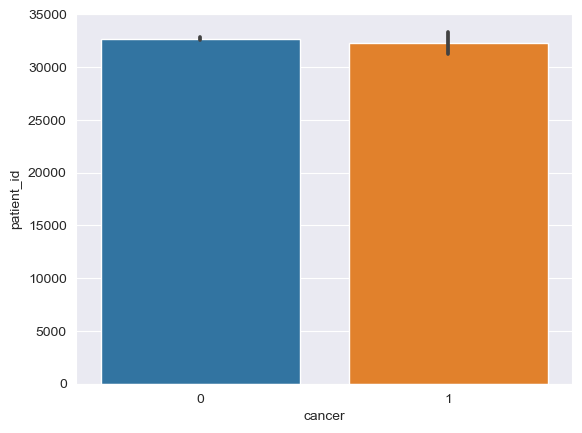

In [6]:
sns.barplot(df_train, x="cancer" , y="patient_id") # acho que esse gráfico não fez muito sentido, mas é isso por enquanto.

In [15]:
df_train.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,28.000000,56.0,56.000000
mean,1.482143,37802.303571,9.863131e+08,59.946429,0.035714,0.089286,0.017857,0.642857,0.0,58.357143
std,0.504203,20426.317696,5.855047e+08,10.305197,0.187256,0.287736,0.133631,0.678467,0.0,47.356454
min,1.000000,2288.000000,1.142521e+07,40.000000,0.000000,0.000000,0.000000,0.000000,0.0,21.000000
25%,1.000000,18824.000000,4.628337e+08,53.000000,0.000000,0.000000,0.000000,0.000000,0.0,29.000000
50%,1.000000,42367.000000,9.966327e+08,60.000000,0.000000,0.000000,0.000000,1.000000,0.0,49.000000
75%,2.000000,55447.250000,1.378012e+09,65.000000,0.000000,0.000000,0.000000,1.000000,0.0,49.000000
max,2.000000,65427.000000,2.145403e+09,85.000000,1.000000,1.000000,1.000000,2.000000,0.0,210.000000


In [16]:
#test_image_ids = [image.split()[0] for image in train_imagens]
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
31356,1,43618,1227473979,R,CC,40.0,0,0,0,1.0,0,A,49,False
47865,2,61491,11425212,R,MLO,55.0,0,0,0,0.0,0,NaN,21,True
34892,1,47428,1296942108,L,CC,85.0,0,1,0,0.0,0,C,49,True
50129,1,64083,16383022,R,CC,41.0,0,0,0,1.0,0,C,49,False
29600,1,41581,182846016,R,CC,73.0,0,1,0,0.0,0,C,49,True


In [ ]:
# TODO - Melhorar a visualização das imagens

fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()

images_array_train = list()
patient_ids_train = list()
c = 0
erros = 0
for n, image in enumerate(files_train):
   try:
      image_path = train_images_path.__str__() + '/' + image
      ds = dicom.dcmread(image_path)
      ds.decompress('gdcm')
      image_as_np = ds.pixel_array.astype(np.float32)
      # image_as_np = ds.convert_pixel_data("jpeg_ls")
      # image_as_np = image_as_np.astype(np.float32)
      shape = image_as_np.shape
      image_as_np = resize(image_as_np, (204, 166), anti_aliasing=True)
      images_array_train.append(image_as_np)
      patient_ids_train.append(ds.data_element("PatientID"))
      c += 1
      if c > 4:
         continue 
      print(f"Caminho do arquivo: {image_path}")
      axs[n].imshow(image_as_np, cmap=plt.cm.bone)
      axs[n].grid(False)
   except Exception as e:
      print("Error:", image)
      erros += 1


Caminho do arquivo: ..\..\data\rsna-breast-cancer-detection\train_images/25304/1856007403.dcm
Error: 8259/1951441223.dcm
Error: 7059/214147419.dcm
Caminho do arquivo: ..\..\data\rsna-breast-cancer-detection\train_images/46869/280296053.dcm
Caminho do arquivo: ..\..\data\rsna-breast-cancer-detection\train_images/16018/2136477996.dcm
Error: 16018/2136477996.dcm
Caminho do arquivo: ..\..\data\rsna-breast-cancer-detection\train_images/25269/266791015.dcm
Error: 25269/266791015.dcm
Error: 63274/267410777.dcm
Error: 6912/335753093.dcm
Error: 720/1557924728.dcm
Error: 61840/1606094040.dcm
Error: 64696/305702950.dcm
Error: 60521/1293247303.dcm
Error: 62284/1697528389.dcm
Error: 64222/1551013326.dcm
Error: 9973/1729524723.dcm
Error: 58771/528882963.dcm
Error: 6691/963958391.dcm
Error: 9750/1208494128.dcm
Error: 9794/1417365097.dcm
Error: 60878/656854855.dcm
Error: 59432/554751505.dcm
Error: 59680/1504410285.dcm
Error: 63998/1190599110.dcm
Error: 9611/29246794.dcm
Error: 6613/304869210.dcm
Error

c:\Users\darks\anaconda3\envs\mineracao\lib\site-packages\pydicom\filereader.py:440: UserWarning: End of file reached before delimiter (fffe, e0dd) found in file ..\..\data\rsna-breast-cancer-detection\train_images/58439/1775985615.dcm
  warnings.warn(msg, UserWarning)


Error: 58439/1775985615.dcm
Error: 59592/219576575.dcm
Error: 64890/462522426.dcm
Error: 59356/1110886721.dcm
Error: 9711/644218111.dcm
Error: 64652/1787978479.dcm
Error: 6986/236080958.dcm
Error: 6368/1645949347.dcm
Error: 63103/1838984971.dcm
Error: 63520/1616579445.dcm
Error: 9746/1463315070.dcm
Error: 6673/1282847704.dcm
Error: 8012/2035297303.dcm
Error: 9746/983751012.dcm
Error: 7310/1836190117.dcm
Error: 61863/1691137143.dcm
Error: 64707/881664142.dcm
Error: 9953/76424850.dcm
Error: 59690/2024662716.dcm
Error: 59583/858759701.dcm
Error: 9078/1794323993.dcm
Error: 59601/826463423.dcm
Error: 7151/731258312.dcm
Error: 9559/203061242.dcm
Error: 6659/734832218.dcm
Error: 6659/1877249993.dcm


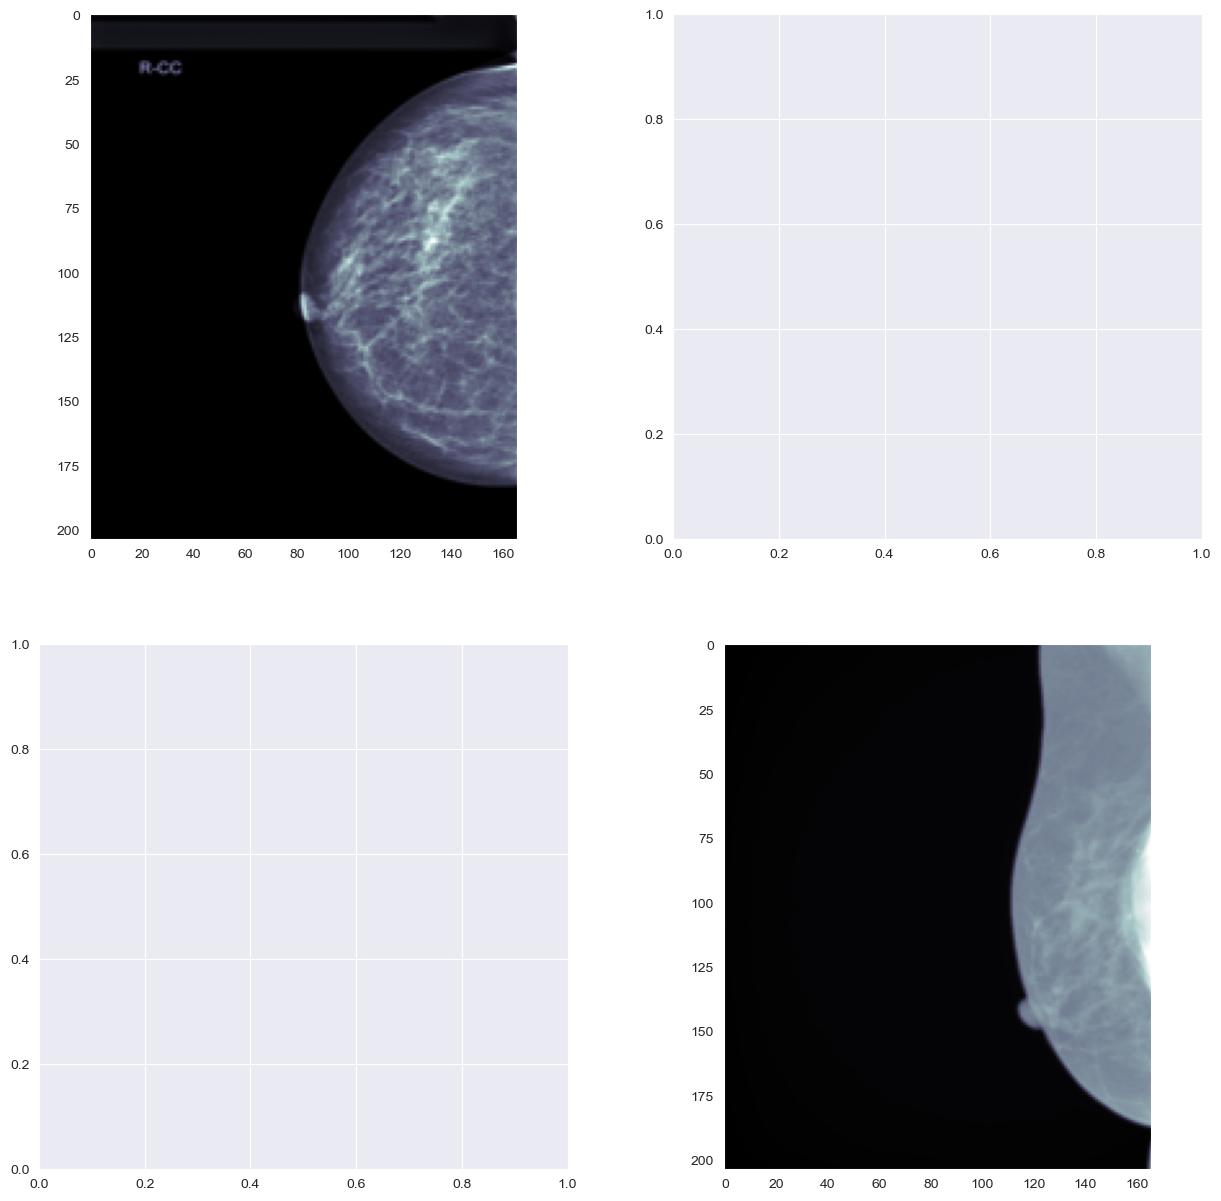

In [ ]:
# TODO - Melhorar a visualização das imagens

fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()

images_array_test = list()
patient_ids_test = list()
c = 0
erros = 0
for n, image in enumerate(files_test):
   try:
      image_path = train_images_path.__str__() + '/' + image
      ds = dicom.dcmread(image_path)
      ds.decompress('gdcm')
      image_as_np = ds.pixel_array.astype(np.float32)
      # image_as_np = ds.convert_pixel_data("jpeg_ls")
      # image_as_np = image_as_np.astype(np.float32)
      shape = image_as_np.shape
      image_as_np = resize(image_as_np, (204, 166), anti_aliasing=True)
      images_array_test.append(image_as_np)
      patient_ids_test.append(ds.data_element("PatientID"))
      c += 1
      if c > 4:
         continue 
      print(f"Caminho do arquivo: {image_path}")
      axs[n].imshow(image_as_np, cmap=plt.cm.bone)
      axs[n].grid(False)
   except Exception as e:
      print("Error:", image)
      erros += 1


In [63]:
images_array_train[0].shape

(204, 166)

In [64]:
print(patient_ids_train)
print(patient_ids_train[0].value) # para acessar o valor do elemento

[(0010, 0020) Patient ID                          LO: '43618', (0010, 0020) Patient ID                          LO: '47428', (0010, 0020) Patient ID                          LO: '41581', (0010, 0020) Patient ID                          LO: '39878', (0010, 0020) Patient ID                          LO: '51945', (0010, 0020) Patient ID                          LO: '5702', (0010, 0020) Patient ID                          LO: '28775', (0010, 0020) Patient ID                          LO: '48748', (0010, 0020) Patient ID                          LO: '54031', (0010, 0020) Patient ID                          LO: '37035', (0010, 0020) Patient ID                          LO: '55164', (0010, 0020) Patient ID                          LO: '29901', (0010, 0020) Patient ID                          LO: '2288', (0010, 0020) Patient ID                          LO: '57798', (0010, 0020) Patient ID                          LO: '18868', (0010, 0020) Patient ID                          LO: '48155', (0010, 00

In [17]:
# não seguir por esse caminho, porque o dicom2jpg salva os arquivos, precisamos fazer o processamento em memória.
# dicom2jpg.dicom2jpg(dcm_folder_path, target_root=jpg_folder_path)

#### 5. Pré-processamento dos dados

In [ ]:
example_rows_train = df_train[df_train["patient_id"].isin([int(id.value) for id in patient_ids_train])]
example_rows_train = example_rows_train.sort_values("image_id")
example_rows_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
42516,1,55822,430666,R,MLO,42.0,0,0,0,1.0,0,C,49,False
26925,2,38764,896533,L,CC,65.0,0,0,0,NaN,0,NaN,29,False
22845,1,34310,1800748,L,CC,86.0,0,0,0,2.0,0,B,93,False
35557,2,4813,2718523,R,CC,64.0,0,0,0,NaN,0,NaN,48,False
26334,1,38149,3105739,L,MLO,67.0,0,0,0,1.0,0,B,49,False


In [ ]:
example_rows_test = df_test[df_test["patient_id"].isin([int(id.value) for id in patient_ids_test])]
example_rows_test = example_rows_test.sort_values("image_id")
example_rows_test.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
4627,1,14995,8964180,L,CC,51.0,0,0,0,1.0,0,C,210,False
29556,1,41555,12663467,L,CC,63.0,0,0,0,2.0,0,B,216,False
36193,2,48858,15065819,R,CC,54.0,0,0,0,NaN,0,NaN,21,False
23356,2,34938,17086266,L,CC,68.0,0,0,0,NaN,0,NaN,29,False
24931,1,3668,22180072,L,MLO,47.0,0,0,0,1.0,1,C,49,False


#### 6. Modelagem

In [ ]:
device = 'cpu'

In [ ]:
# Definir a classe do modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))


In [ ]:
# Definir os parâmetros do modelo
input_size = 166
hidden_size = 128
output_size = 1
num_layers = 2

# Criar uma instância do modelo
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
X_train = torch.from_numpy(np.array(images_array_train)).float().to(device)
y_train = torch.from_numpy(np.array(example_rows_train["cancer"])).float().to(device)

In [ ]:
# Definir o número de épocas de treinamento
num_epochs = 500

# Treinar o modelo
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Printar informações de treinamento
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.1938
Epoch [20/500], Loss: 0.1181
Epoch [30/500], Loss: 0.1099
Epoch [40/500], Loss: 0.1081
Epoch [50/500], Loss: 0.1071
Epoch [60/500], Loss: 0.1067
Epoch [70/500], Loss: 0.1060
Epoch [80/500], Loss: 0.1053
Epoch [90/500], Loss: 0.1043
Epoch [100/500], Loss: 0.1032
Epoch [110/500], Loss: 0.1016
Epoch [120/500], Loss: 0.0997
Epoch [130/500], Loss: 0.0972
Epoch [140/500], Loss: 0.0937
Epoch [150/500], Loss: 0.0882
Epoch [160/500], Loss: 0.0848
Epoch [170/500], Loss: 0.0799
Epoch [180/500], Loss: 0.0753
Epoch [190/500], Loss: 0.0665
Epoch [200/500], Loss: 0.0651
Epoch [210/500], Loss: 0.0579
Epoch [220/500], Loss: 0.0517
Epoch [230/500], Loss: 0.0434
Epoch [240/500], Loss: 0.0467
Epoch [250/500], Loss: 0.0459
Epoch [260/500], Loss: 0.0506
Epoch [270/500], Loss: 0.0364
Epoch [280/500], Loss: 0.0366
Epoch [290/500], Loss: 0.0301
Epoch [300/500], Loss: 0.0449
Epoch [310/500], Loss: 0.0340
Epoch [320/500], Loss: 0.0273
Epoch [330/500], Loss: 0.0245
Epoch [340/500], Lo

In [ ]:
X_test = torch.from_numpy(np.array(images_array_test)).float().to(device)
y_test = torch.from_numpy(np.array(example_rows_test["cancer"])).float().to(device)

In [ ]:
# Testar o modelo
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
y_pred = list(map(int, (np.array(y_pred) > 0.5)))

In [ ]:
import sklearn
from sklearn import metrics
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
import seaborn as sn
from pretty_confusion_matrix import pp_matrix

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9714640198511166

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)

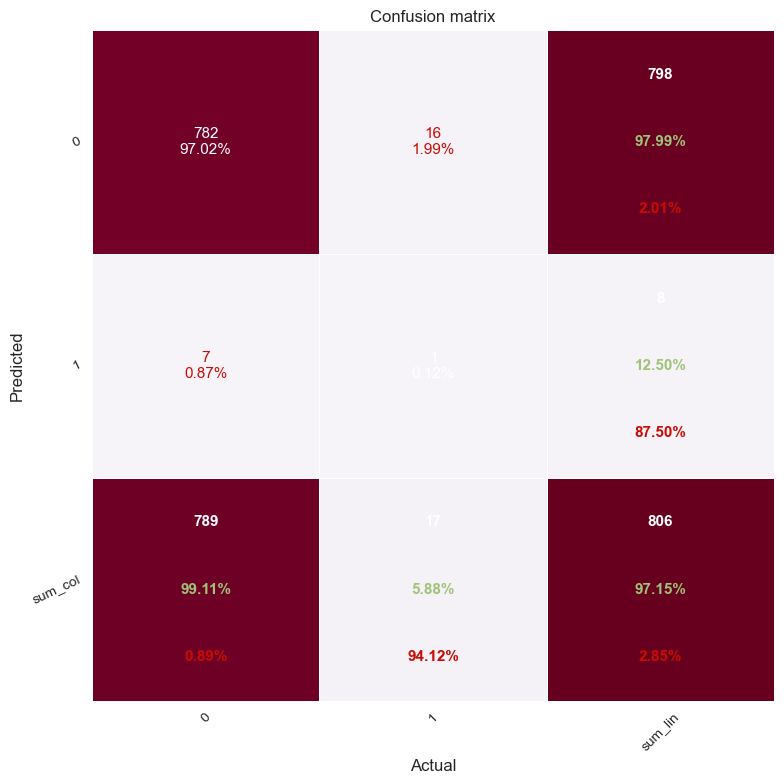

In [ ]:
df_cm = pd.DataFrame(cm, index = [0,1], columns = [0,1])
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [ ]:
clf_report = metrics.classification_report(y_test,
                                   y_pred,
                                   labels=[0,1],
                                   target_names=[0,1],
                                   output_dict=True)

<Axes: >

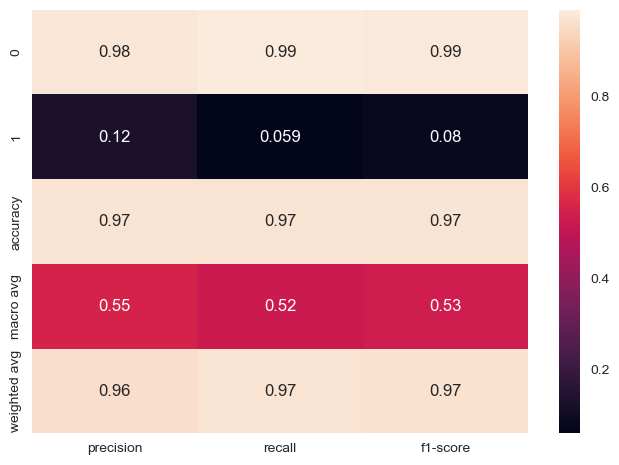

In [ ]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)